In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "02"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-gbrt-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-gbrt-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-gbrt-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
categ_feats = [
    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]
len(input_feats)

1562

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting':'gbdt',
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=3000,
            callbacks=[
                lgb.log_evaluation(period=50), 
                lgb.early_stopping(300, first_metric_only=True)
            ],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.766385	valid_0's recall_at4: 0.624337	valid_0's norm_gini: 0.908433


[100]	valid_0's amex_metric: 0.778695	valid_0's recall_at4: 0.641757	valid_0's norm_gini: 0.915632


[150]	valid_0's amex_metric: 0.784794	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.919246


[200]	valid_0's amex_metric: 0.788446	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921165


[250]	valid_0's amex_metric: 0.790853	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.922276


[300]	valid_0's amex_metric: 0.792854	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.922997


[350]	valid_0's amex_metric: 0.793234	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.923462


[400]	valid_0's amex_metric: 0.79419	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.923858


[450]	valid_0's amex_metric: 0.794302	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924126


[500]	valid_0's amex_metric: 0.795251	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.92434


[550]	valid_0's amex_metric: 0.795951	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.924477


[600]	valid_0's amex_metric: 0.795705	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924576


[650]	valid_0's amex_metric: 0.796507	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924665


[700]	valid_0's amex_metric: 0.796759	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924748


[750]	valid_0's amex_metric: 0.797129	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.924814


[800]	valid_0's amex_metric: 0.797173	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924861


[850]	valid_0's amex_metric: 0.797349	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.924917


[900]	valid_0's amex_metric: 0.797424	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.92494


[950]	valid_0's amex_metric: 0.797416	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.924967


[1000]	valid_0's amex_metric: 0.79698	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.925021


[1050]	valid_0's amex_metric: 0.796556	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925057


Early stopping, best iteration is:
[786]	valid_0's amex_metric: 0.797692	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.924846
Evaluated only: amex_metric


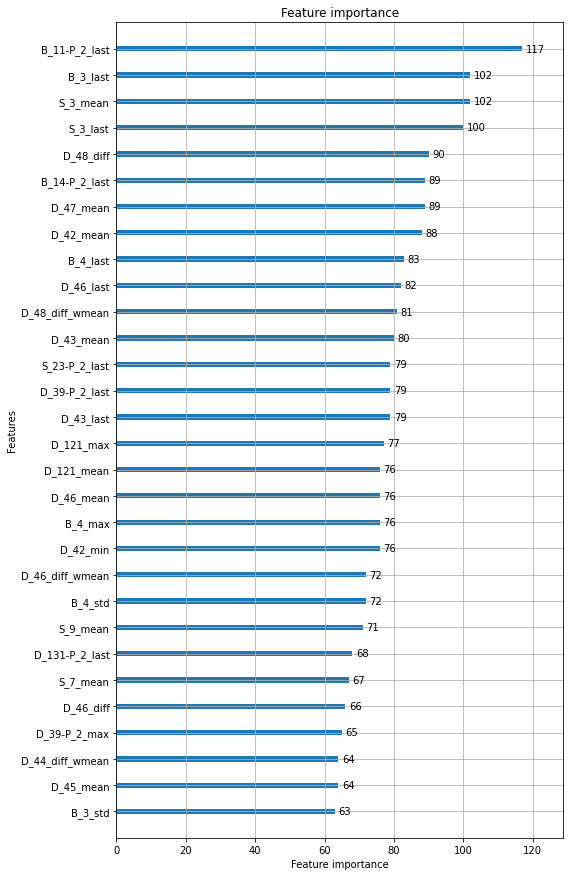

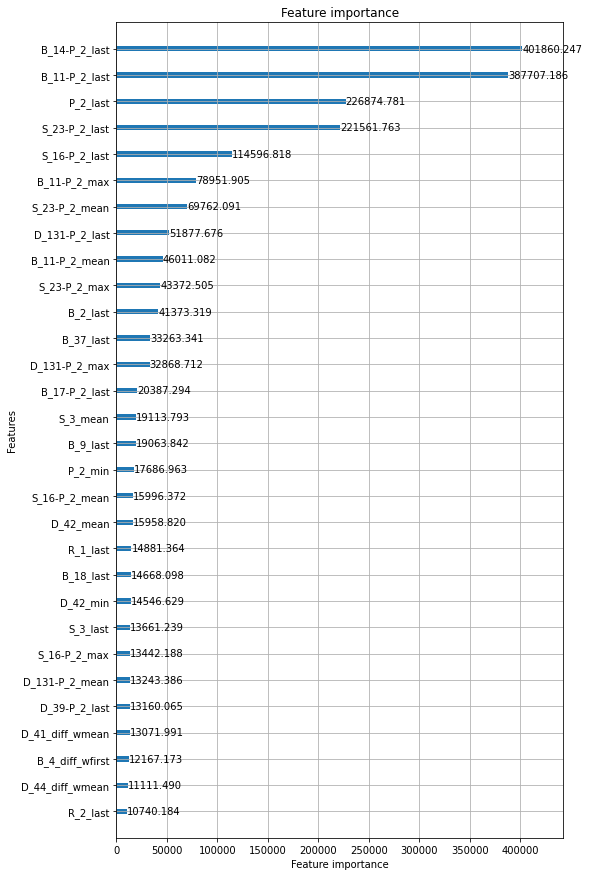

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.763628	valid_0's recall_at4: 0.619835	valid_0's norm_gini: 0.907421


[100]	valid_0's amex_metric: 0.775781	valid_0's recall_at4: 0.637044	valid_0's norm_gini: 0.914518


[150]	valid_0's amex_metric: 0.783273	valid_0's recall_at4: 0.648195	valid_0's norm_gini: 0.918352


[200]	valid_0's amex_metric: 0.786699	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.920322


[250]	valid_0's amex_metric: 0.789388	valid_0's recall_at4: 0.657283	valid_0's norm_gini: 0.921493


[300]	valid_0's amex_metric: 0.790408	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.922313


[350]	valid_0's amex_metric: 0.792228	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922839


[400]	valid_0's amex_metric: 0.793155	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923219


[450]	valid_0's amex_metric: 0.79366	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.923515


[500]	valid_0's amex_metric: 0.794432	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.923796


[550]	valid_0's amex_metric: 0.794938	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924051


[600]	valid_0's amex_metric: 0.795351	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924245


[650]	valid_0's amex_metric: 0.795114	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924362


[700]	valid_0's amex_metric: 0.795614	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924477


[750]	valid_0's amex_metric: 0.795884	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924512


[800]	valid_0's amex_metric: 0.795575	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.924611


[850]	valid_0's amex_metric: 0.796074	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924639


[900]	valid_0's amex_metric: 0.795518	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.924663


[950]	valid_0's amex_metric: 0.795464	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924725


[1000]	valid_0's amex_metric: 0.795672	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.924803


[1050]	valid_0's amex_metric: 0.795894	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.924827


[1100]	valid_0's amex_metric: 0.795657	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924858


[1150]	valid_0's amex_metric: 0.795251	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924887


[1200]	valid_0's amex_metric: 0.795636	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.9249


[1250]	valid_0's amex_metric: 0.795896	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924914


[1300]	valid_0's amex_metric: 0.796225	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924943


Early stopping, best iteration is:
[1028]	valid_0's amex_metric: 0.796497	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.924812
Evaluated only: amex_metric


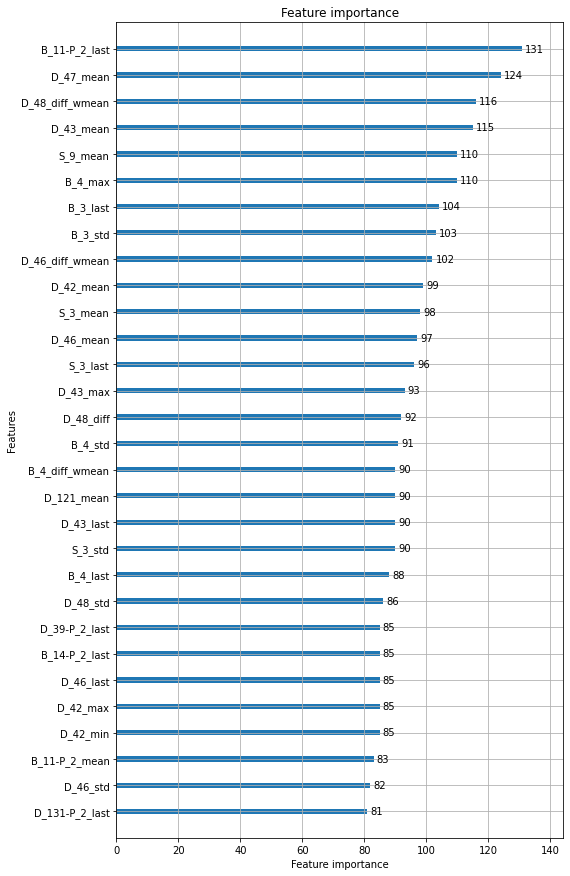

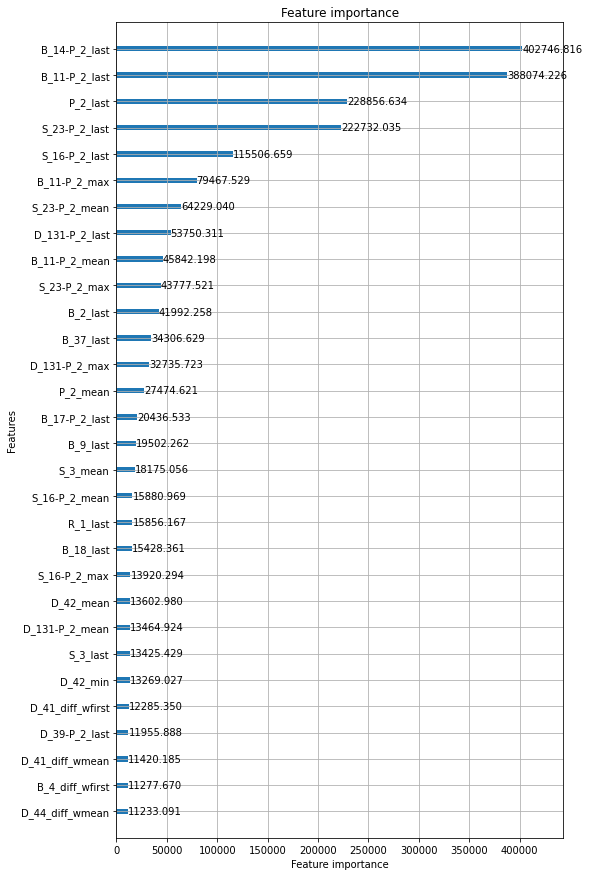

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.759385	valid_0's recall_at4: 0.612009	valid_0's norm_gini: 0.906762


[100]	valid_0's amex_metric: 0.771266	valid_0's recall_at4: 0.629008	valid_0's norm_gini: 0.913524


[150]	valid_0's amex_metric: 0.778379	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.917021


[200]	valid_0's amex_metric: 0.781964	valid_0's recall_at4: 0.644955	valid_0's norm_gini: 0.918973


[250]	valid_0's amex_metric: 0.783066	valid_0's recall_at4: 0.646049	valid_0's norm_gini: 0.920083


[300]	valid_0's amex_metric: 0.784844	valid_0's recall_at4: 0.648868	valid_0's norm_gini: 0.92082


[350]	valid_0's amex_metric: 0.786197	valid_0's recall_at4: 0.651056	valid_0's norm_gini: 0.921338


[400]	valid_0's amex_metric: 0.786754	valid_0's recall_at4: 0.651771	valid_0's norm_gini: 0.921736


[450]	valid_0's amex_metric: 0.787599	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921996


[500]	valid_0's amex_metric: 0.787546	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.922226


[550]	valid_0's amex_metric: 0.788493	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922437


[600]	valid_0's amex_metric: 0.789303	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.922627


[650]	valid_0's amex_metric: 0.788698	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.922721


[700]	valid_0's amex_metric: 0.789577	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.922839


[750]	valid_0's amex_metric: 0.789535	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.922922


[800]	valid_0's amex_metric: 0.789491	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.923003


[850]	valid_0's amex_metric: 0.789913	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.923089


[900]	valid_0's amex_metric: 0.789578	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.923093


[950]	valid_0's amex_metric: 0.789759	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.923118


[1000]	valid_0's amex_metric: 0.790018	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.923131


[1050]	valid_0's amex_metric: 0.789291	valid_0's recall_at4: 0.655432	valid_0's norm_gini: 0.92315


[1100]	valid_0's amex_metric: 0.789569	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.923159


[1150]	valid_0's amex_metric: 0.789517	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.923139


[1200]	valid_0's amex_metric: 0.789428	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.923129


[1250]	valid_0's amex_metric: 0.789372	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.923144


Early stopping, best iteration is:
[980]	valid_0's amex_metric: 0.790733	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.92313
Evaluated only: amex_metric


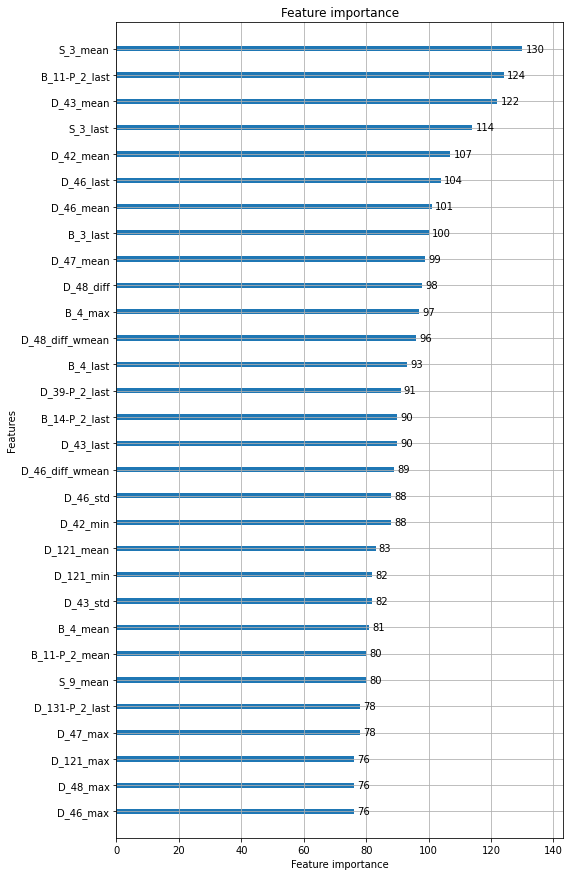

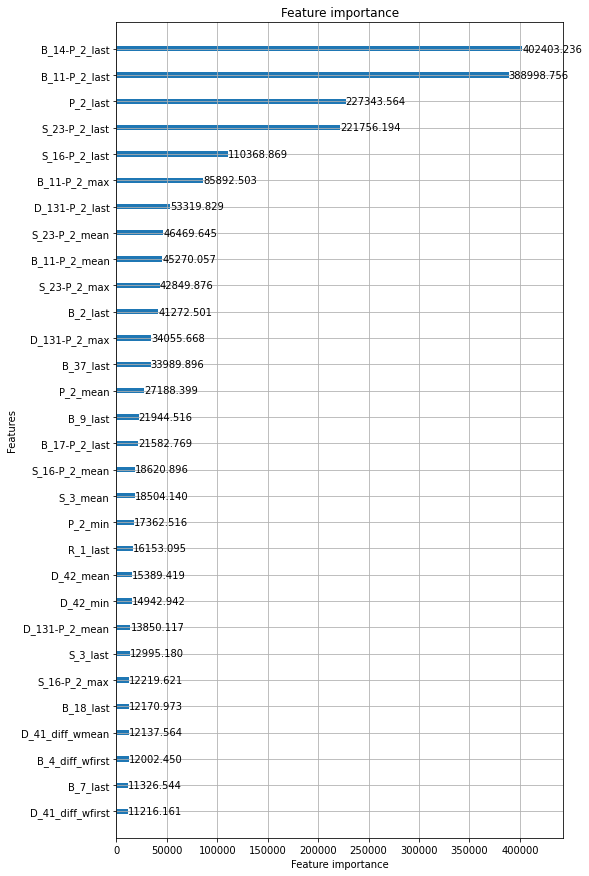

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.759799	valid_0's recall_at4: 0.613297	valid_0's norm_gini: 0.906302


[100]	valid_0's amex_metric: 0.771416	valid_0's recall_at4: 0.629581	valid_0's norm_gini: 0.913251


[150]	valid_0's amex_metric: 0.777236	valid_0's recall_at4: 0.63745	valid_0's norm_gini: 0.917023


[200]	valid_0's amex_metric: 0.780692	valid_0's recall_at4: 0.642247	valid_0's norm_gini: 0.919137


[250]	valid_0's amex_metric: 0.783558	valid_0's recall_at4: 0.646707	valid_0's norm_gini: 0.920409


[300]	valid_0's amex_metric: 0.785172	valid_0's recall_at4: 0.649106	valid_0's norm_gini: 0.921239


[350]	valid_0's amex_metric: 0.785761	valid_0's recall_at4: 0.649653	valid_0's norm_gini: 0.921869


[400]	valid_0's amex_metric: 0.7866	valid_0's recall_at4: 0.650873	valid_0's norm_gini: 0.922328


[450]	valid_0's amex_metric: 0.78618	valid_0's recall_at4: 0.649695	valid_0's norm_gini: 0.922666


[500]	valid_0's amex_metric: 0.786846	valid_0's recall_at4: 0.650789	valid_0's norm_gini: 0.922903


[550]	valid_0's amex_metric: 0.787493	valid_0's recall_at4: 0.651841	valid_0's norm_gini: 0.923144


[600]	valid_0's amex_metric: 0.787738	valid_0's recall_at4: 0.652178	valid_0's norm_gini: 0.923299


[650]	valid_0's amex_metric: 0.788338	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.923447


[700]	valid_0's amex_metric: 0.788684	valid_0's recall_at4: 0.653777	valid_0's norm_gini: 0.923592


[750]	valid_0's amex_metric: 0.788604	valid_0's recall_at4: 0.653524	valid_0's norm_gini: 0.923683


[800]	valid_0's amex_metric: 0.788922	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.923772


[850]	valid_0's amex_metric: 0.78904	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.923841


[900]	valid_0's amex_metric: 0.788904	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.923905


[950]	valid_0's amex_metric: 0.78939	valid_0's recall_at4: 0.654786	valid_0's norm_gini: 0.923993


[1000]	valid_0's amex_metric: 0.789887	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.924061


[1050]	valid_0's amex_metric: 0.790157	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.92414


[1100]	valid_0's amex_metric: 0.790334	valid_0's recall_at4: 0.656512	valid_0's norm_gini: 0.924157


[1150]	valid_0's amex_metric: 0.790169	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.924162


[1200]	valid_0's amex_metric: 0.790377	valid_0's recall_at4: 0.656554	valid_0's norm_gini: 0.924201


[1250]	valid_0's amex_metric: 0.790622	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.924227


[1300]	valid_0's amex_metric: 0.790472	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.924265


[1350]	valid_0's amex_metric: 0.790952	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.924257


[1400]	valid_0's amex_metric: 0.790451	valid_0's recall_at4: 0.656638	valid_0's norm_gini: 0.924264


[1450]	valid_0's amex_metric: 0.791756	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.924307


[1500]	valid_0's amex_metric: 0.791609	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924309


[1550]	valid_0's amex_metric: 0.791727	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924333


[1600]	valid_0's amex_metric: 0.791316	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.924354


[1650]	valid_0's amex_metric: 0.791506	valid_0's recall_at4: 0.658658	valid_0's norm_gini: 0.924354


[1700]	valid_0's amex_metric: 0.791778	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924394


[1750]	valid_0's amex_metric: 0.791602	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.92442


[1800]	valid_0's amex_metric: 0.790928	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.924418


[1850]	valid_0's amex_metric: 0.791017	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.924428


[1900]	valid_0's amex_metric: 0.791119	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.924422


[1950]	valid_0's amex_metric: 0.790957	valid_0's recall_at4: 0.657522	valid_0's norm_gini: 0.924391


[2000]	valid_0's amex_metric: 0.79061	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.924372


[2050]	valid_0's amex_metric: 0.790544	valid_0's recall_at4: 0.656722	valid_0's norm_gini: 0.924367


Early stopping, best iteration is:
[1757]	valid_0's amex_metric: 0.791981	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.924421
Evaluated only: amex_metric


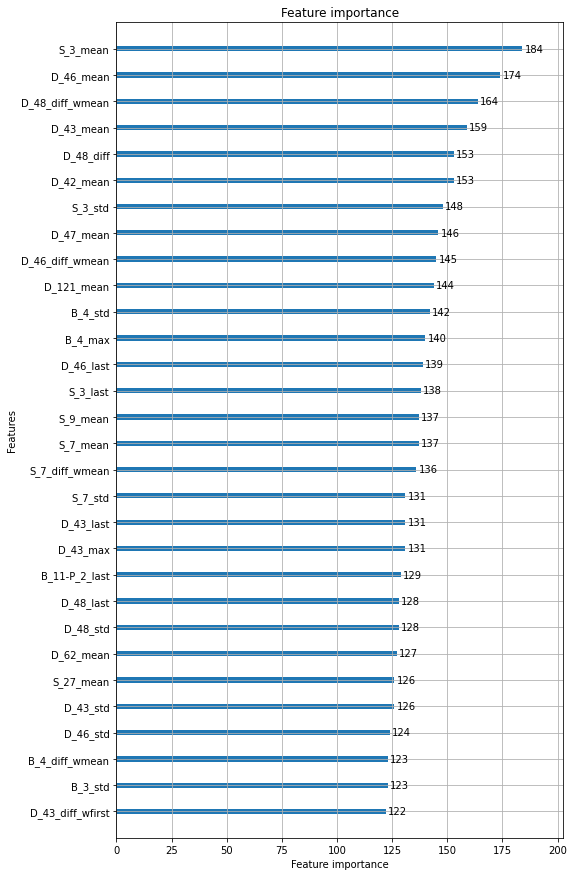

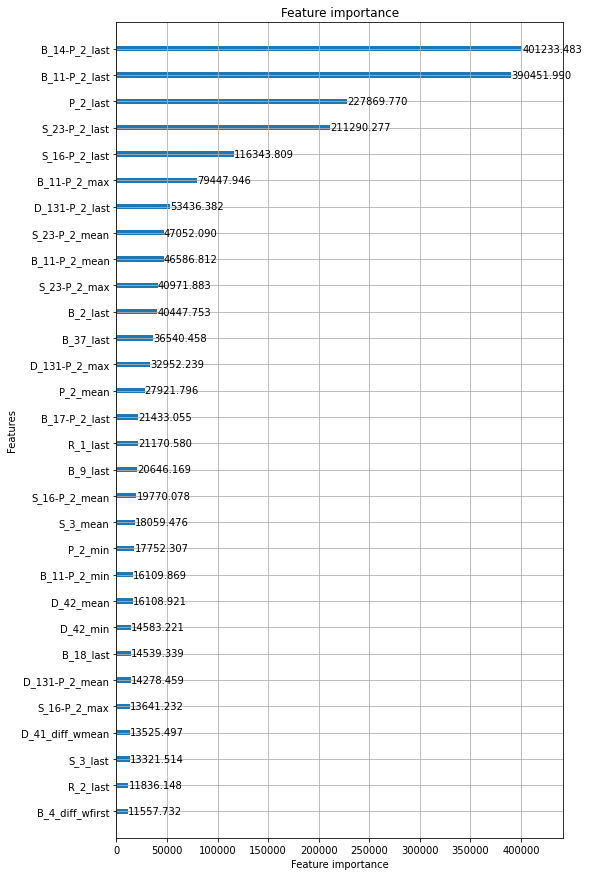

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.768082	valid_0's recall_at4: 0.626299	valid_0's norm_gini: 0.909866


[100]	valid_0's amex_metric: 0.781197	valid_0's recall_at4: 0.645613	valid_0's norm_gini: 0.91678


[150]	valid_0's amex_metric: 0.788185	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.920406


[200]	valid_0's amex_metric: 0.791746	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.922393


[250]	valid_0's amex_metric: 0.7939	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.923588


[300]	valid_0's amex_metric: 0.795159	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.924297


[350]	valid_0's amex_metric: 0.796589	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924801


[400]	valid_0's amex_metric: 0.797339	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925207


[450]	valid_0's amex_metric: 0.797347	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.925432


[500]	valid_0's amex_metric: 0.797875	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925606


[550]	valid_0's amex_metric: 0.798476	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.925754


[600]	valid_0's amex_metric: 0.798401	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.925941


[650]	valid_0's amex_metric: 0.799287	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925988


[700]	valid_0's amex_metric: 0.800095	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.926089


[750]	valid_0's amex_metric: 0.799632	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926174


[800]	valid_0's amex_metric: 0.799831	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926234


[850]	valid_0's amex_metric: 0.799981	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.926283


[900]	valid_0's amex_metric: 0.800334	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926315


[950]	valid_0's amex_metric: 0.799975	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.926354


[1000]	valid_0's amex_metric: 0.800068	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.926373


[1050]	valid_0's amex_metric: 0.80038	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926408


[1100]	valid_0's amex_metric: 0.799989	valid_0's recall_at4: 0.673554	valid_0's norm_gini: 0.926424


[1150]	valid_0's amex_metric: 0.799932	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926437


[1200]	valid_0's amex_metric: 0.79996	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.92645


[1250]	valid_0's amex_metric: 0.800208	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.926484


[1300]	valid_0's amex_metric: 0.80026	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.926503


[1350]	valid_0's amex_metric: 0.800171	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.926535


Early stopping, best iteration is:
[1055]	valid_0's amex_metric: 0.800783	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.926413
Evaluated only: amex_metric


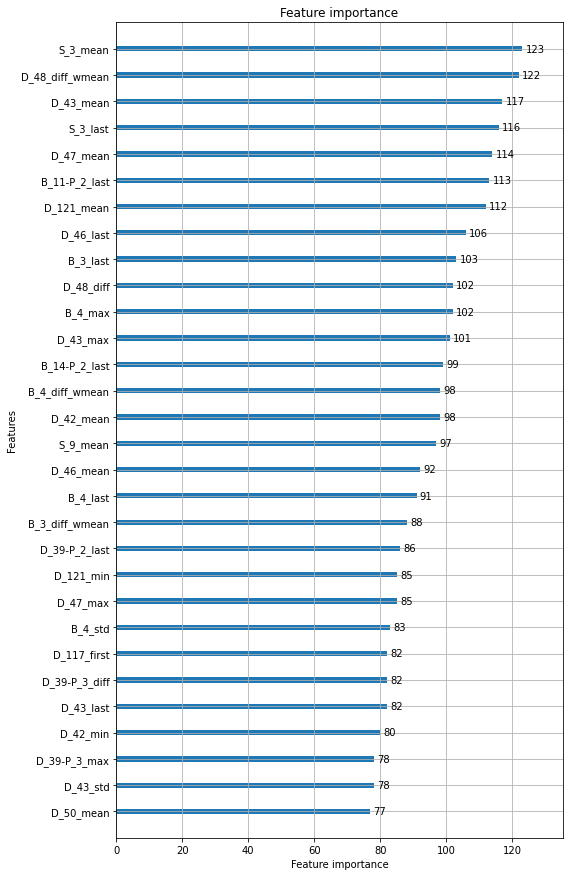

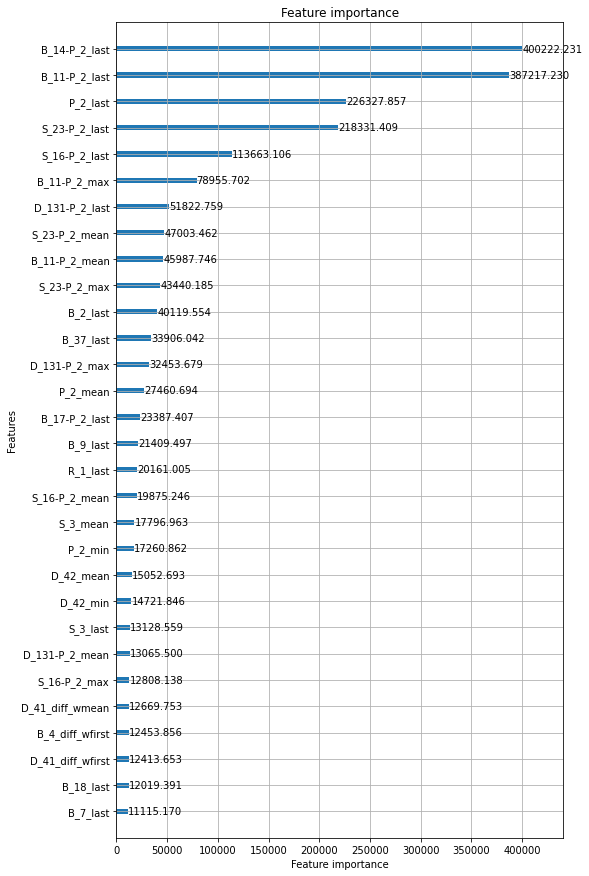

Training time: 16.4713227947553 min.


OOF recall_at4: 0.6652640791732588


OOF normalized_gini: 0.9245906254250275


OOF competition metric: 0.7949273522991431


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.766711	valid_0's recall_at4: 0.6248	valid_0's norm_gini: 0.908621


[100]	valid_0's amex_metric: 0.778758	valid_0's recall_at4: 0.641925	valid_0's norm_gini: 0.91559


[150]	valid_0's amex_metric: 0.785838	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.919315


[200]	valid_0's amex_metric: 0.790447	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.921254


[250]	valid_0's amex_metric: 0.791168	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.922485


[300]	valid_0's amex_metric: 0.793364	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923258


[350]	valid_0's amex_metric: 0.794668	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.923806


[400]	valid_0's amex_metric: 0.795466	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.924223


[450]	valid_0's amex_metric: 0.795491	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924527


[500]	valid_0's amex_metric: 0.795493	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.924699


[550]	valid_0's amex_metric: 0.795068	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.924858


[600]	valid_0's amex_metric: 0.795758	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.925017


[650]	valid_0's amex_metric: 0.796112	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925136


[700]	valid_0's amex_metric: 0.796318	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.925169


[750]	valid_0's amex_metric: 0.796383	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925258


[800]	valid_0's amex_metric: 0.796665	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925316


[850]	valid_0's amex_metric: 0.797019	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.925351


[900]	valid_0's amex_metric: 0.797256	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925405


[950]	valid_0's amex_metric: 0.797486	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925445


[1000]	valid_0's amex_metric: 0.797879	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925472


[1050]	valid_0's amex_metric: 0.797339	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925529


[1100]	valid_0's amex_metric: 0.796677	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.925551


[1150]	valid_0's amex_metric: 0.796799	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925584


[1200]	valid_0's amex_metric: 0.79653	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.925594


[1250]	valid_0's amex_metric: 0.795986	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.925558


Early stopping, best iteration is:
[969]	valid_0's amex_metric: 0.798022	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925465
Evaluated only: amex_metric


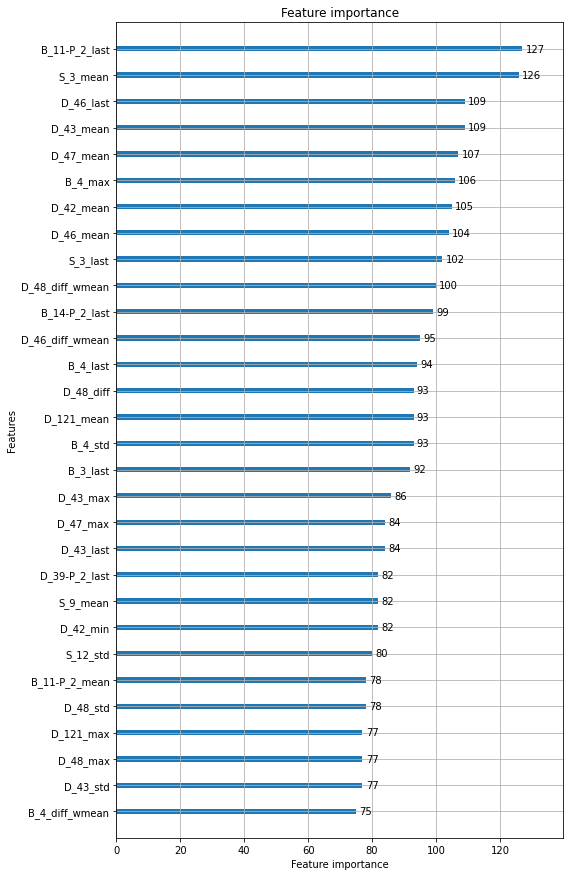

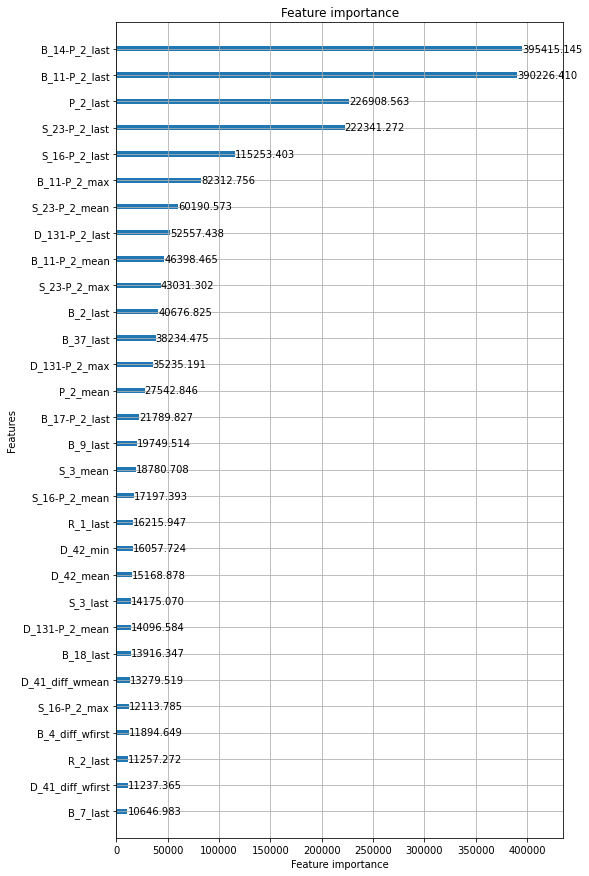

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.761447	valid_0's recall_at4: 0.615375	valid_0's norm_gini: 0.907518


[100]	valid_0's amex_metric: 0.774106	valid_0's recall_at4: 0.633847	valid_0's norm_gini: 0.914366


[150]	valid_0's amex_metric: 0.781233	valid_0's recall_at4: 0.644408	valid_0's norm_gini: 0.918057


[200]	valid_0's amex_metric: 0.784555	valid_0's recall_at4: 0.649121	valid_0's norm_gini: 0.919989


[250]	valid_0's amex_metric: 0.785892	valid_0's recall_at4: 0.650593	valid_0's norm_gini: 0.921191


[300]	valid_0's amex_metric: 0.787633	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.921896


[350]	valid_0's amex_metric: 0.787718	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.922445


[400]	valid_0's amex_metric: 0.789455	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.922846


[450]	valid_0's amex_metric: 0.790365	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.923153


[500]	valid_0's amex_metric: 0.790941	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923335


[550]	valid_0's amex_metric: 0.790883	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923515


[600]	valid_0's amex_metric: 0.790925	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.92364


[650]	valid_0's amex_metric: 0.791073	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.923726


[700]	valid_0's amex_metric: 0.79131	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.923822


[750]	valid_0's amex_metric: 0.79129	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.923907


[800]	valid_0's amex_metric: 0.792139	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.923965


[850]	valid_0's amex_metric: 0.792212	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.924026


[900]	valid_0's amex_metric: 0.792544	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.924059


[950]	valid_0's amex_metric: 0.792412	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.92409


[1000]	valid_0's amex_metric: 0.792382	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.924157


[1050]	valid_0's amex_metric: 0.791961	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924198


[1100]	valid_0's amex_metric: 0.792201	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.924215


[1150]	valid_0's amex_metric: 0.791413	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.924239


[1200]	valid_0's amex_metric: 0.791802	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.924259


[1250]	valid_0's amex_metric: 0.791936	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.924274


[1300]	valid_0's amex_metric: 0.792367	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.924295


Early stopping, best iteration is:
[1020]	valid_0's amex_metric: 0.792817	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.924185
Evaluated only: amex_metric


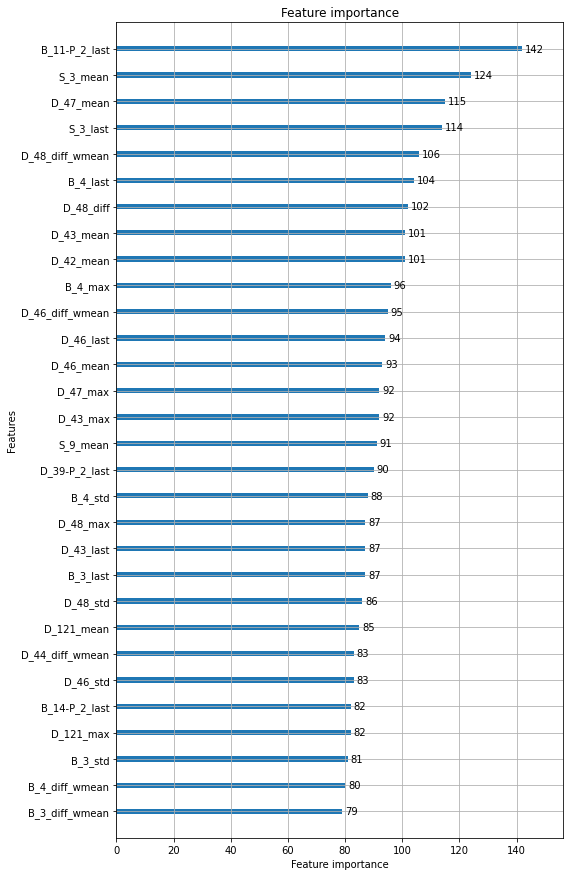

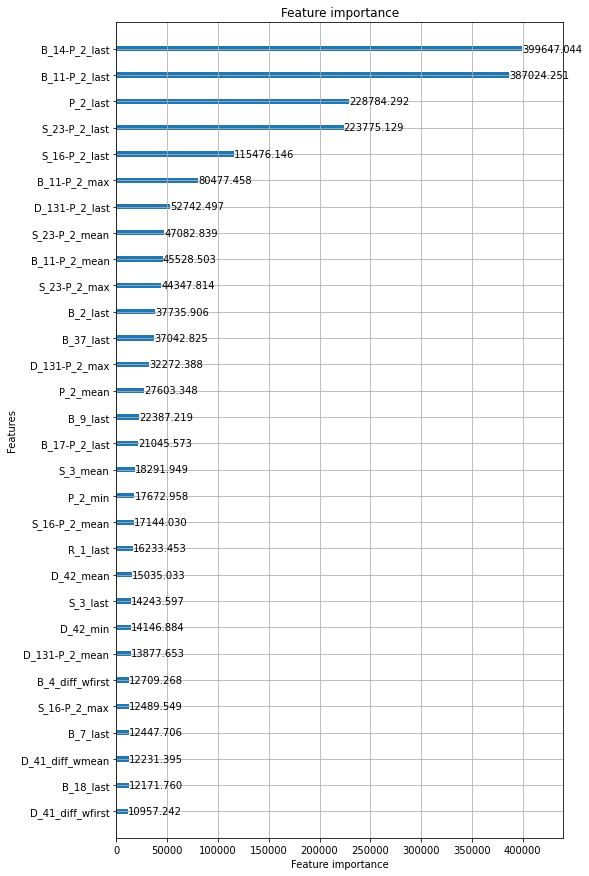

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.760028	valid_0's recall_at4: 0.614071	valid_0's norm_gini: 0.905985


[100]	valid_0's amex_metric: 0.771015	valid_0's recall_at4: 0.628797	valid_0's norm_gini: 0.913233


[150]	valid_0's amex_metric: 0.777972	valid_0's recall_at4: 0.638896	valid_0's norm_gini: 0.917048


[200]	valid_0's amex_metric: 0.782222	valid_0's recall_at4: 0.645292	valid_0's norm_gini: 0.919153


[250]	valid_0's amex_metric: 0.785487	valid_0's recall_at4: 0.650551	valid_0's norm_gini: 0.920422


[300]	valid_0's amex_metric: 0.787732	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.921253


[350]	valid_0's amex_metric: 0.788628	valid_0's recall_at4: 0.655432	valid_0's norm_gini: 0.921824


[400]	valid_0's amex_metric: 0.78925	valid_0's recall_at4: 0.656232	valid_0's norm_gini: 0.922268


[450]	valid_0's amex_metric: 0.790079	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.92258


[500]	valid_0's amex_metric: 0.790517	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922784


[550]	valid_0's amex_metric: 0.79093	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.922936


[600]	valid_0's amex_metric: 0.790981	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.923122


[650]	valid_0's amex_metric: 0.790413	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.923206


[700]	valid_0's amex_metric: 0.791182	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.923356


[750]	valid_0's amex_metric: 0.791671	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.92345


[800]	valid_0's amex_metric: 0.79125	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.923491


[850]	valid_0's amex_metric: 0.791303	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.923556


[900]	valid_0's amex_metric: 0.792241	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.923622


[950]	valid_0's amex_metric: 0.792135	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923704


[1000]	valid_0's amex_metric: 0.792126	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923729


[1050]	valid_0's amex_metric: 0.792053	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923751


[1100]	valid_0's amex_metric: 0.792418	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.923765


[1150]	valid_0's amex_metric: 0.792647	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.923761


[1200]	valid_0's amex_metric: 0.792043	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.923774


[1250]	valid_0's amex_metric: 0.791964	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.923782


[1300]	valid_0's amex_metric: 0.792165	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923807


[1350]	valid_0's amex_metric: 0.791593	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.9238


[1400]	valid_0's amex_metric: 0.791372	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.92382


Early stopping, best iteration is:
[1107]	valid_0's amex_metric: 0.79274	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.923779
Evaluated only: amex_metric


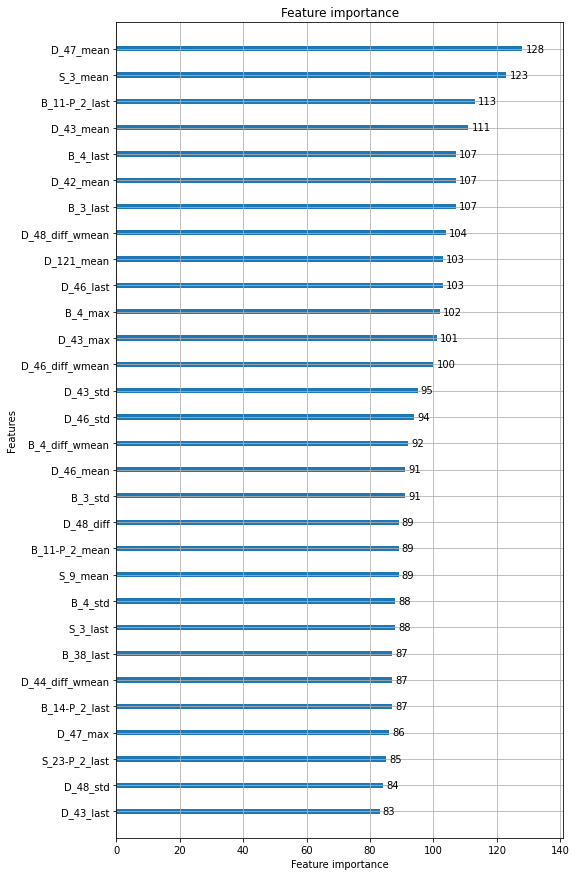

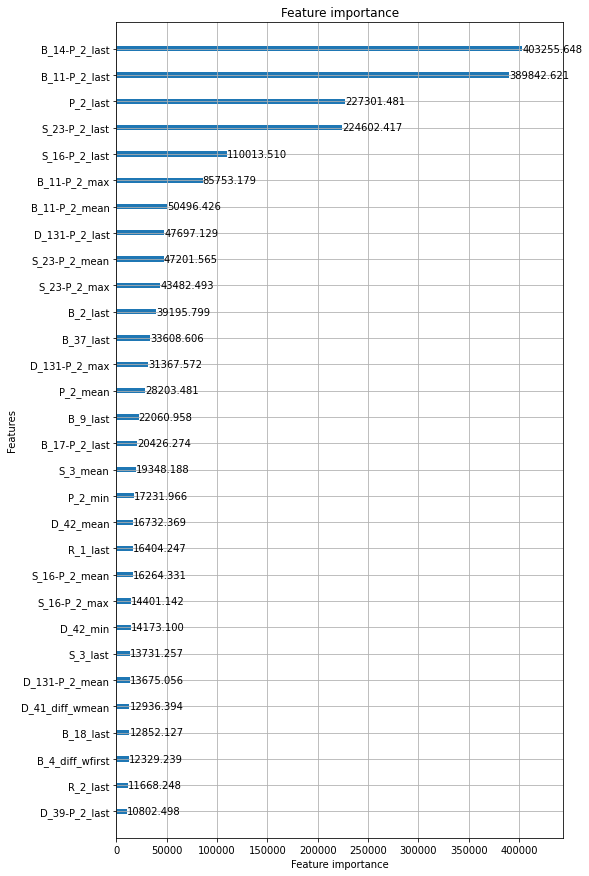

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.764958	valid_0's recall_at4: 0.621713	valid_0's norm_gini: 0.908203


[100]	valid_0's amex_metric: 0.778887	valid_0's recall_at4: 0.642626	valid_0's norm_gini: 0.915148


[150]	valid_0's amex_metric: 0.784674	valid_0's recall_at4: 0.650621	valid_0's norm_gini: 0.918727


[200]	valid_0's amex_metric: 0.788173	valid_0's recall_at4: 0.65567	valid_0's norm_gini: 0.920676


[250]	valid_0's amex_metric: 0.790387	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.921821


[300]	valid_0's amex_metric: 0.79229	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.922556


[350]	valid_0's amex_metric: 0.793625	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.923039


[400]	valid_0's amex_metric: 0.794325	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.92347


[450]	valid_0's amex_metric: 0.795054	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.923751


[500]	valid_0's amex_metric: 0.795936	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.92404


[550]	valid_0's amex_metric: 0.796738	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.924256


[600]	valid_0's amex_metric: 0.796938	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.924362


[650]	valid_0's amex_metric: 0.796752	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.924494


[700]	valid_0's amex_metric: 0.796495	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924613


[750]	valid_0's amex_metric: 0.797085	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.924698


[800]	valid_0's amex_metric: 0.796629	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.924796


[850]	valid_0's amex_metric: 0.797085	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.924866


[900]	valid_0's amex_metric: 0.7975	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.924896


[950]	valid_0's amex_metric: 0.797681	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.924922


[1000]	valid_0's amex_metric: 0.797048	valid_0's recall_at4: 0.669135	valid_0's norm_gini: 0.92496


[1050]	valid_0's amex_metric: 0.797163	valid_0's recall_at4: 0.669346	valid_0's norm_gini: 0.92498


[1100]	valid_0's amex_metric: 0.797567	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.924988


[1150]	valid_0's amex_metric: 0.797382	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.924997


[1200]	valid_0's amex_metric: 0.796704	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.92503


[1250]	valid_0's amex_metric: 0.796955	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925069


Early stopping, best iteration is:
[969]	valid_0's amex_metric: 0.797975	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.924921
Evaluated only: amex_metric


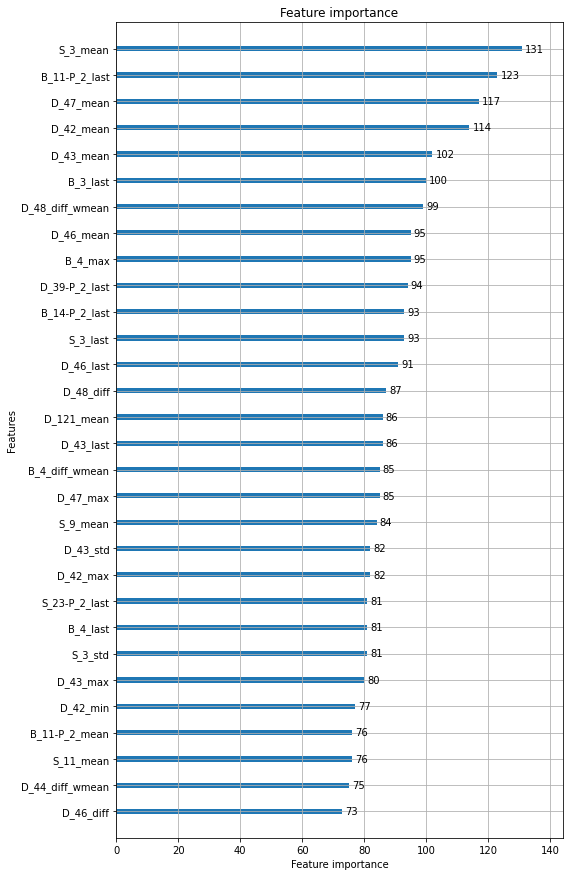

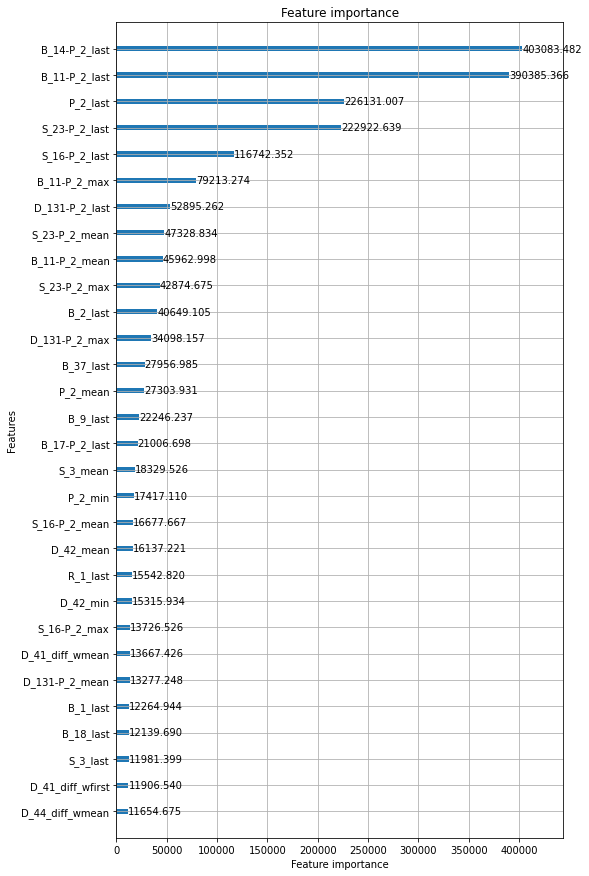

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.765914	valid_0's recall_at4: 0.623312	valid_0's norm_gini: 0.908517


[100]	valid_0's amex_metric: 0.776764	valid_0's recall_at4: 0.638081	valid_0's norm_gini: 0.915447


[150]	valid_0's amex_metric: 0.783857	valid_0's recall_at4: 0.648685	valid_0's norm_gini: 0.91903


[200]	valid_0's amex_metric: 0.787901	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.920889


[250]	valid_0's amex_metric: 0.78967	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.922071


[300]	valid_0's amex_metric: 0.791783	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.922805


[350]	valid_0's amex_metric: 0.792547	valid_0's recall_at4: 0.661729	valid_0's norm_gini: 0.923364


[400]	valid_0's amex_metric: 0.792537	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.923724


[450]	valid_0's amex_metric: 0.79346	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.924053


[500]	valid_0's amex_metric: 0.793812	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.924253


[550]	valid_0's amex_metric: 0.794624	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.924488


[600]	valid_0's amex_metric: 0.794955	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.924646


[650]	valid_0's amex_metric: 0.794863	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924799


[700]	valid_0's amex_metric: 0.795189	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.924904


[750]	valid_0's amex_metric: 0.795166	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.924985


[800]	valid_0's amex_metric: 0.795472	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.92509


[850]	valid_0's amex_metric: 0.795366	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.925172


[900]	valid_0's amex_metric: 0.795689	valid_0's recall_at4: 0.66619	valid_0's norm_gini: 0.925188


[950]	valid_0's amex_metric: 0.79567	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925234


[1000]	valid_0's amex_metric: 0.795694	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925283


[1050]	valid_0's amex_metric: 0.7953	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.925335


[1100]	valid_0's amex_metric: 0.795672	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.925364


[1150]	valid_0's amex_metric: 0.795952	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925419


[1200]	valid_0's amex_metric: 0.79554	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925438


[1250]	valid_0's amex_metric: 0.795973	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.925504


[1300]	valid_0's amex_metric: 0.796384	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.925526


[1350]	valid_0's amex_metric: 0.79579	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.925558


[1400]	valid_0's amex_metric: 0.796444	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925563


[1450]	valid_0's amex_metric: 0.7959	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925567


[1500]	valid_0's amex_metric: 0.795946	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.925575


[1550]	valid_0's amex_metric: 0.796356	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.925596


[1600]	valid_0's amex_metric: 0.796569	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.925602


[1650]	valid_0's amex_metric: 0.796123	valid_0's recall_at4: 0.666653	valid_0's norm_gini: 0.925594


[1700]	valid_0's amex_metric: 0.796835	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.925586


[1750]	valid_0's amex_metric: 0.79647	valid_0's recall_at4: 0.667368	valid_0's norm_gini: 0.925572


[1800]	valid_0's amex_metric: 0.796661	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925576


[1850]	valid_0's amex_metric: 0.79654	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.925585


[1900]	valid_0's amex_metric: 0.795984	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.925609


[1950]	valid_0's amex_metric: 0.796395	valid_0's recall_at4: 0.6672	valid_0's norm_gini: 0.92559


[2000]	valid_0's amex_metric: 0.796407	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.925571


Early stopping, best iteration is:
[1717]	valid_0's amex_metric: 0.796978	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925579
Evaluated only: amex_metric


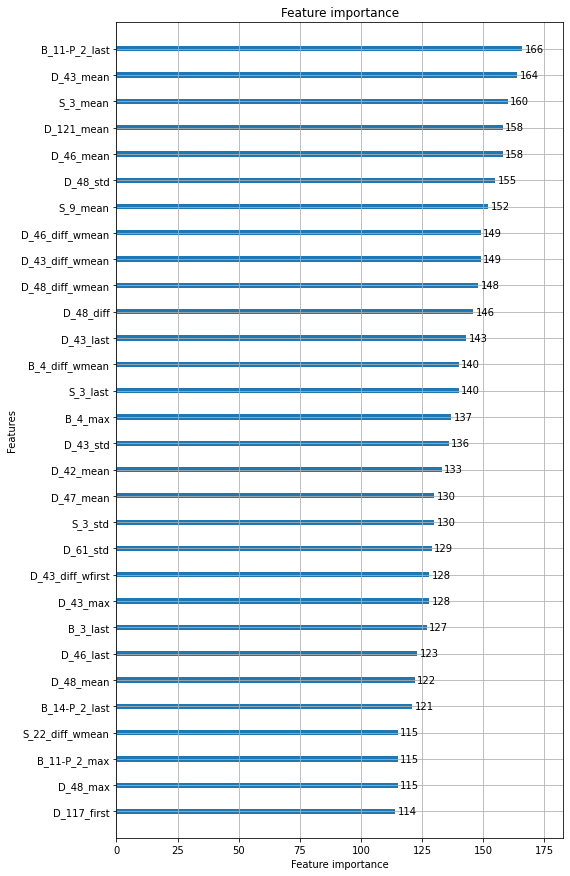

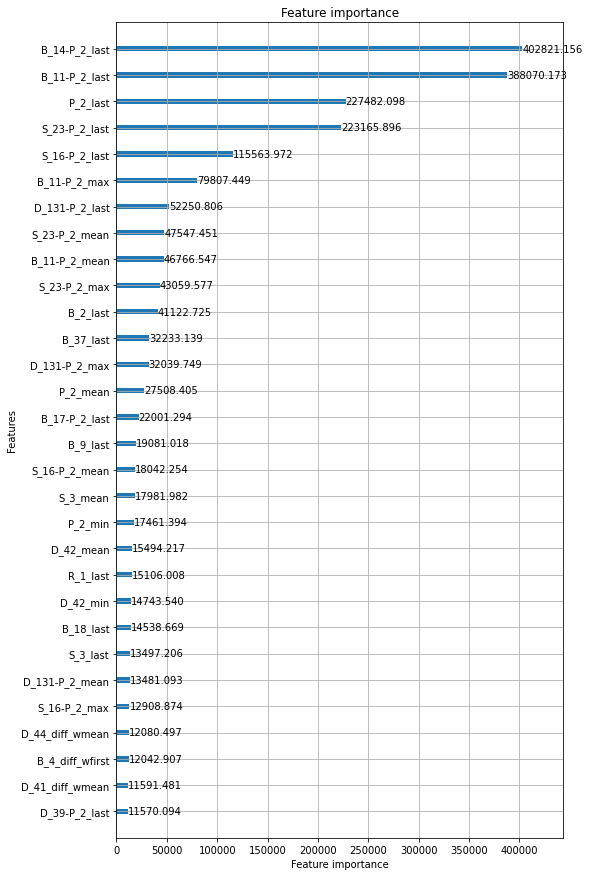

Training time: 16.464408612251283 min.
OOF recall_at4: 0.6660719695694618
OOF normalized_gini: 0.9246518847057345
OOF competition metric: 0.7953619271375981


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.759824	valid_0's recall_at4: 0.613229	valid_0's norm_gini: 0.906419


[100]	valid_0's amex_metric: 0.77346	valid_0's recall_at4: 0.633342	valid_0's norm_gini: 0.913578


[150]	valid_0's amex_metric: 0.78058	valid_0's recall_at4: 0.643945	valid_0's norm_gini: 0.917214


[200]	valid_0's amex_metric: 0.784914	valid_0's recall_at4: 0.650635	valid_0's norm_gini: 0.919193


[250]	valid_0's amex_metric: 0.786453	valid_0's recall_at4: 0.652571	valid_0's norm_gini: 0.920336


[300]	valid_0's amex_metric: 0.788813	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.921099


[350]	valid_0's amex_metric: 0.789834	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.921628


[400]	valid_0's amex_metric: 0.790713	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.922038


[450]	valid_0's amex_metric: 0.790736	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.922296


[500]	valid_0's amex_metric: 0.791238	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922541


[550]	valid_0's amex_metric: 0.79154	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.922724


[600]	valid_0's amex_metric: 0.792231	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922845


[650]	valid_0's amex_metric: 0.792187	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.922967


[700]	valid_0's amex_metric: 0.79256	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.92304


[750]	valid_0's amex_metric: 0.791892	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923135


[800]	valid_0's amex_metric: 0.792462	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.923181


[850]	valid_0's amex_metric: 0.791941	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923232


[900]	valid_0's amex_metric: 0.792483	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.923264


[950]	valid_0's amex_metric: 0.79223	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.923348


[1000]	valid_0's amex_metric: 0.792842	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.92335


[1050]	valid_0's amex_metric: 0.792466	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.923356


[1100]	valid_0's amex_metric: 0.792313	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.923345


[1150]	valid_0's amex_metric: 0.792201	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923374


[1200]	valid_0's amex_metric: 0.792057	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.92338


[1250]	valid_0's amex_metric: 0.79209	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923404


[1300]	valid_0's amex_metric: 0.791991	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923416


Early stopping, best iteration is:
[1005]	valid_0's amex_metric: 0.793029	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.923346
Evaluated only: amex_metric


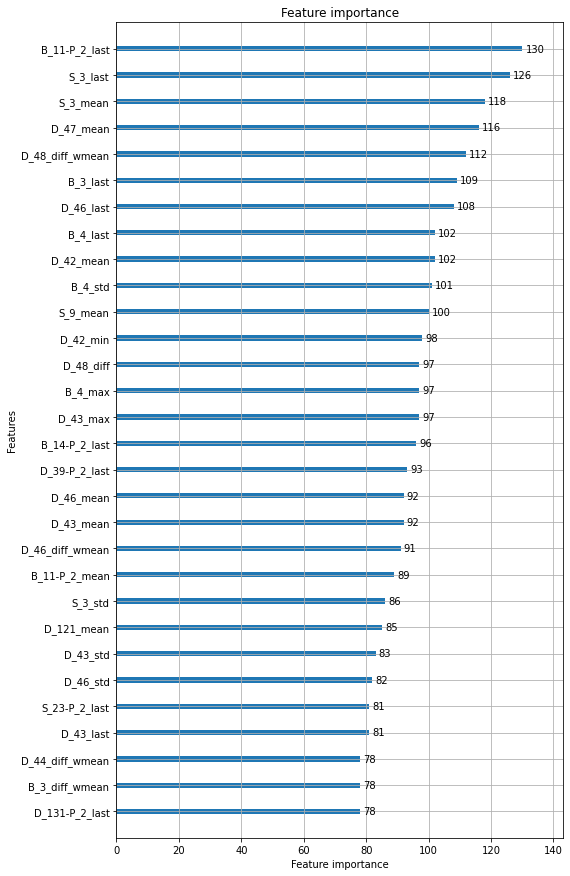

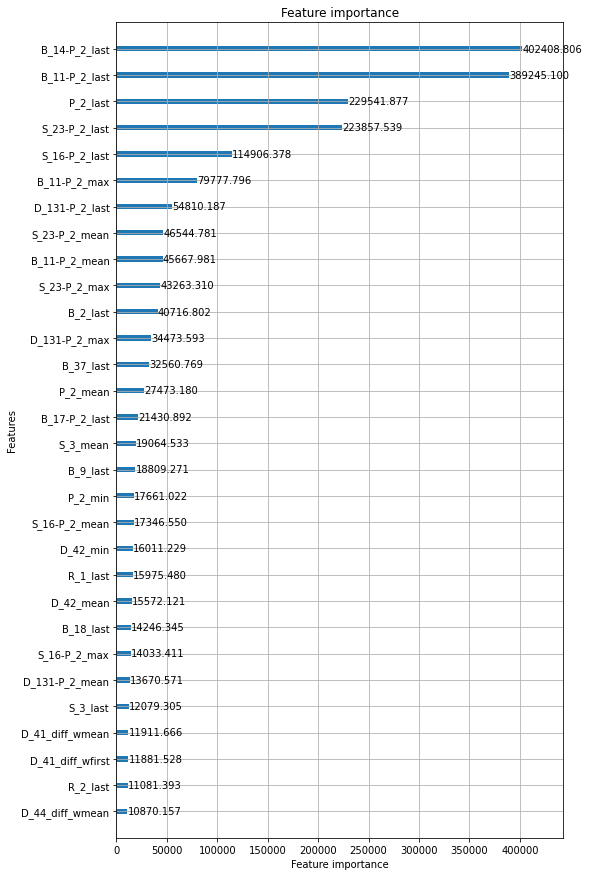

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.761013	valid_0's recall_at4: 0.614239	valid_0's norm_gini: 0.907787


[100]	valid_0's amex_metric: 0.77174	valid_0's recall_at4: 0.628966	valid_0's norm_gini: 0.914514


[150]	valid_0's amex_metric: 0.778205	valid_0's recall_at4: 0.638181	valid_0's norm_gini: 0.91823


[200]	valid_0's amex_metric: 0.781443	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.920161


[250]	valid_0's amex_metric: 0.784255	valid_0's recall_at4: 0.647227	valid_0's norm_gini: 0.921284


[300]	valid_0's amex_metric: 0.784378	valid_0's recall_at4: 0.646722	valid_0's norm_gini: 0.922034


[350]	valid_0's amex_metric: 0.785302	valid_0's recall_at4: 0.648027	valid_0's norm_gini: 0.922577


[400]	valid_0's amex_metric: 0.786118	valid_0's recall_at4: 0.649247	valid_0's norm_gini: 0.922989


[450]	valid_0's amex_metric: 0.786762	valid_0's recall_at4: 0.650215	valid_0's norm_gini: 0.923309


[500]	valid_0's amex_metric: 0.786953	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.923565


[550]	valid_0's amex_metric: 0.787818	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.923781


[600]	valid_0's amex_metric: 0.78806	valid_0's recall_at4: 0.652234	valid_0's norm_gini: 0.923886


[650]	valid_0's amex_metric: 0.788531	valid_0's recall_at4: 0.653034	valid_0's norm_gini: 0.924028


[700]	valid_0's amex_metric: 0.788959	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.924128


[750]	valid_0's amex_metric: 0.789211	valid_0's recall_at4: 0.65417	valid_0's norm_gini: 0.924252


[800]	valid_0's amex_metric: 0.789386	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.924349


[850]	valid_0's amex_metric: 0.789045	valid_0's recall_at4: 0.653665	valid_0's norm_gini: 0.924424


[900]	valid_0's amex_metric: 0.789687	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.924489


[950]	valid_0's amex_metric: 0.789842	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.924505


[1000]	valid_0's amex_metric: 0.789513	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.92452


[1050]	valid_0's amex_metric: 0.789432	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.924568


[1100]	valid_0's amex_metric: 0.789711	valid_0's recall_at4: 0.654801	valid_0's norm_gini: 0.924621


[1150]	valid_0's amex_metric: 0.790125	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.924692


[1200]	valid_0's amex_metric: 0.790167	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.924734


[1250]	valid_0's amex_metric: 0.790264	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.924718


[1300]	valid_0's amex_metric: 0.78981	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.924734


[1350]	valid_0's amex_metric: 0.790516	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.924758


[1400]	valid_0's amex_metric: 0.790669	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.92477


[1450]	valid_0's amex_metric: 0.791091	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.924771


[1500]	valid_0's amex_metric: 0.790777	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.924775


[1550]	valid_0's amex_metric: 0.789968	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.924798


[1600]	valid_0's amex_metric: 0.790323	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.924792


[1650]	valid_0's amex_metric: 0.790439	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.924815


[1700]	valid_0's amex_metric: 0.79028	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.924833


Early stopping, best iteration is:
[1440]	valid_0's amex_metric: 0.791306	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.924782
Evaluated only: amex_metric


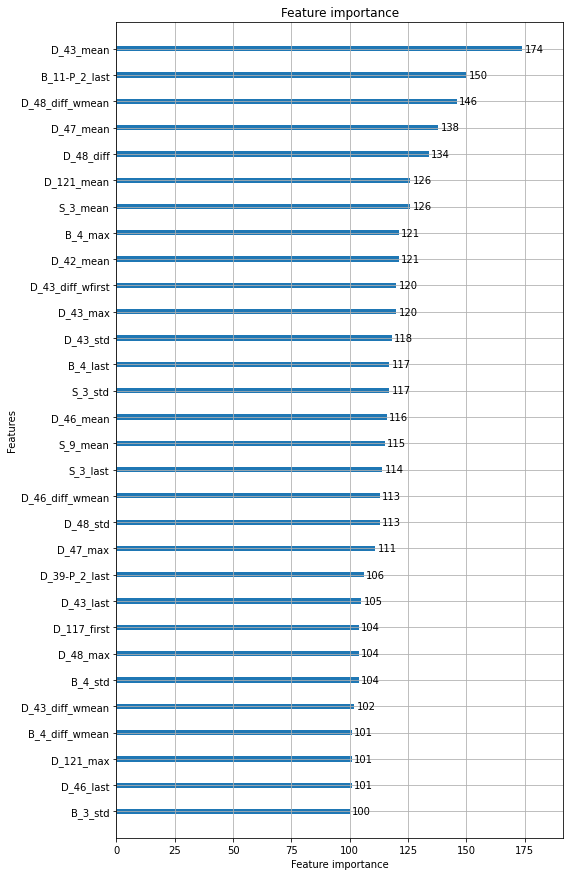

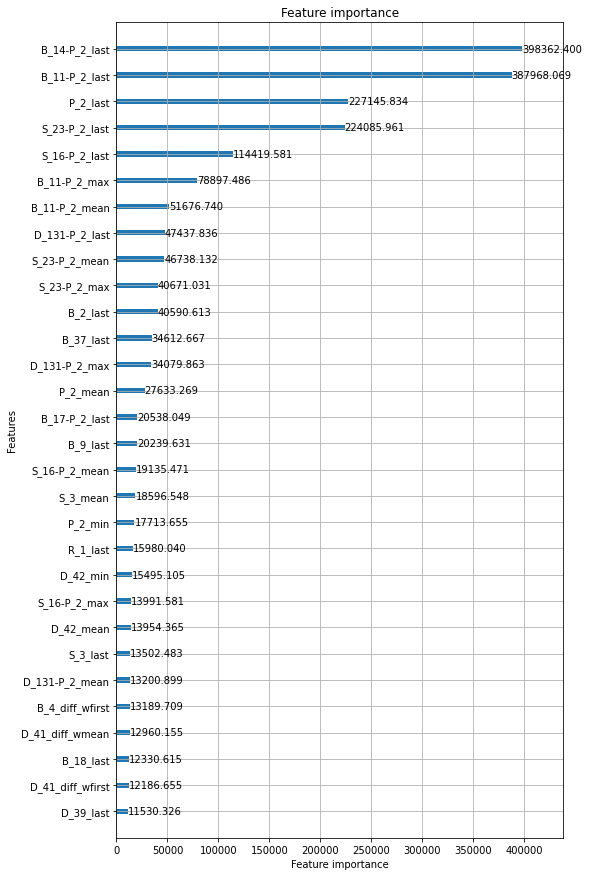

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.764509	valid_0's recall_at4: 0.622276	valid_0's norm_gini: 0.906742


[100]	valid_0's amex_metric: 0.777473	valid_0's recall_at4: 0.640705	valid_0's norm_gini: 0.914241


[150]	valid_0's amex_metric: 0.783576	valid_0's recall_at4: 0.649036	valid_0's norm_gini: 0.918116


[200]	valid_0's amex_metric: 0.787599	valid_0's recall_at4: 0.654969	valid_0's norm_gini: 0.920228


[250]	valid_0's amex_metric: 0.78906	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.921468


[300]	valid_0's amex_metric: 0.791346	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.922336


[350]	valid_0's amex_metric: 0.792157	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.922865


[400]	valid_0's amex_metric: 0.793412	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923314


[450]	valid_0's amex_metric: 0.794602	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.92359


[500]	valid_0's amex_metric: 0.794826	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923827


[550]	valid_0's amex_metric: 0.794871	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924002


[600]	valid_0's amex_metric: 0.795216	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924186


[650]	valid_0's amex_metric: 0.795943	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924379


[700]	valid_0's amex_metric: 0.796226	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924522


[750]	valid_0's amex_metric: 0.796262	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.924637


[800]	valid_0's amex_metric: 0.796751	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.924732


[850]	valid_0's amex_metric: 0.796739	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.924791


[900]	valid_0's amex_metric: 0.797158	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.924872


[950]	valid_0's amex_metric: 0.797175	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.924948


[1000]	valid_0's amex_metric: 0.797238	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924991


[1050]	valid_0's amex_metric: 0.797405	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925029


[1100]	valid_0's amex_metric: 0.796963	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925028


[1150]	valid_0's amex_metric: 0.797319	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925025


[1200]	valid_0's amex_metric: 0.797008	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.924993


[1250]	valid_0's amex_metric: 0.797143	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.92501


Early stopping, best iteration is:
[953]	valid_0's amex_metric: 0.797727	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.924957
Evaluated only: amex_metric


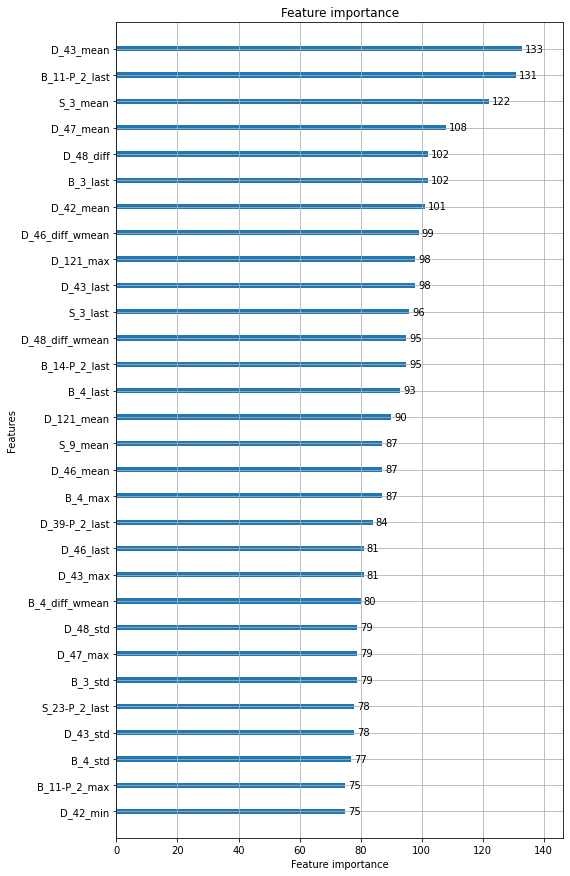

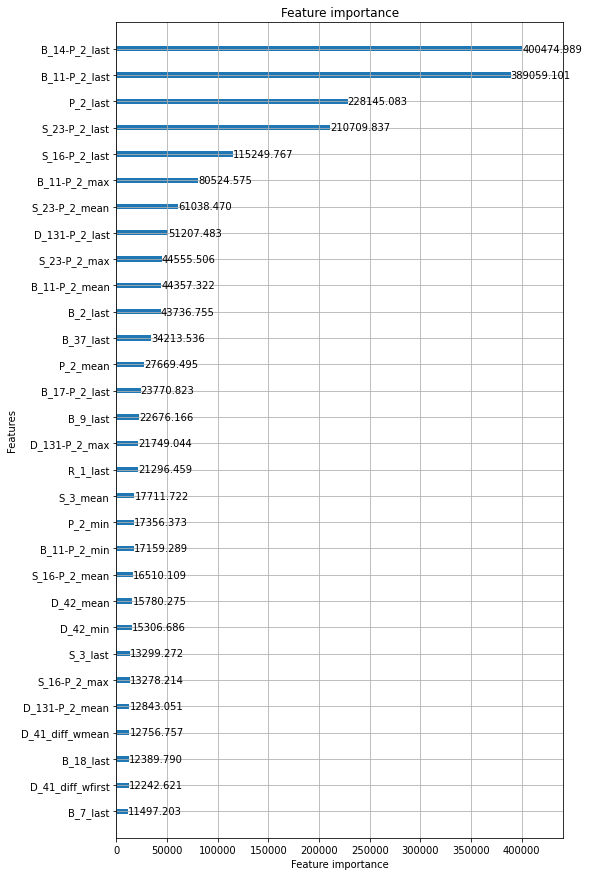

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.768993	valid_0's recall_at4: 0.627435	valid_0's norm_gini: 0.91055


[100]	valid_0's amex_metric: 0.781648	valid_0's recall_at4: 0.645824	valid_0's norm_gini: 0.917472


[150]	valid_0's amex_metric: 0.788409	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.92119


[200]	valid_0's amex_metric: 0.792401	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.923198


[250]	valid_0's amex_metric: 0.794695	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924379


[300]	valid_0's amex_metric: 0.795722	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.925127


[350]	valid_0's amex_metric: 0.797452	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925685


[400]	valid_0's amex_metric: 0.79872	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926117


[450]	valid_0's amex_metric: 0.799675	valid_0's recall_at4: 0.672964	valid_0's norm_gini: 0.926386


[500]	valid_0's amex_metric: 0.800044	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926619


[550]	valid_0's amex_metric: 0.800458	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926857


[600]	valid_0's amex_metric: 0.800487	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.926958


[650]	valid_0's amex_metric: 0.801266	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.927084


[700]	valid_0's amex_metric: 0.801133	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927155


[750]	valid_0's amex_metric: 0.801254	valid_0's recall_at4: 0.675279	valid_0's norm_gini: 0.927229


[800]	valid_0's amex_metric: 0.800996	valid_0's recall_at4: 0.67469	valid_0's norm_gini: 0.927302


[850]	valid_0's amex_metric: 0.801126	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927352


[900]	valid_0's amex_metric: 0.800625	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.92736


[950]	valid_0's amex_metric: 0.801242	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.927415


[1000]	valid_0's amex_metric: 0.80171	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927469


[1050]	valid_0's amex_metric: 0.801308	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927505


[1100]	valid_0's amex_metric: 0.801445	valid_0's recall_at4: 0.675363	valid_0's norm_gini: 0.927528


[1150]	valid_0's amex_metric: 0.801337	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927563


[1200]	valid_0's amex_metric: 0.8017	valid_0's recall_at4: 0.675784	valid_0's norm_gini: 0.927617


[1250]	valid_0's amex_metric: 0.8014	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.927648


[1300]	valid_0's amex_metric: 0.801226	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.927678


Early stopping, best iteration is:
[1022]	valid_0's amex_metric: 0.802148	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927502
Evaluated only: amex_metric


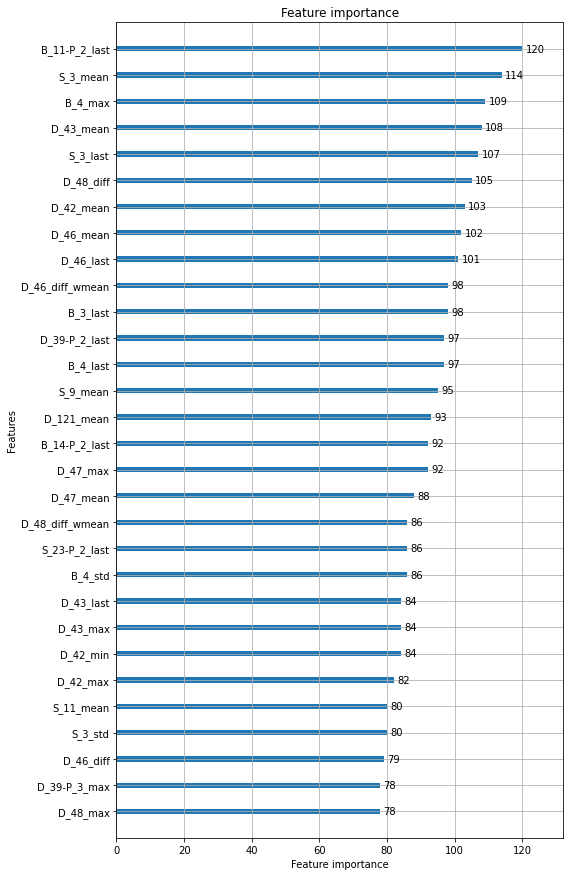

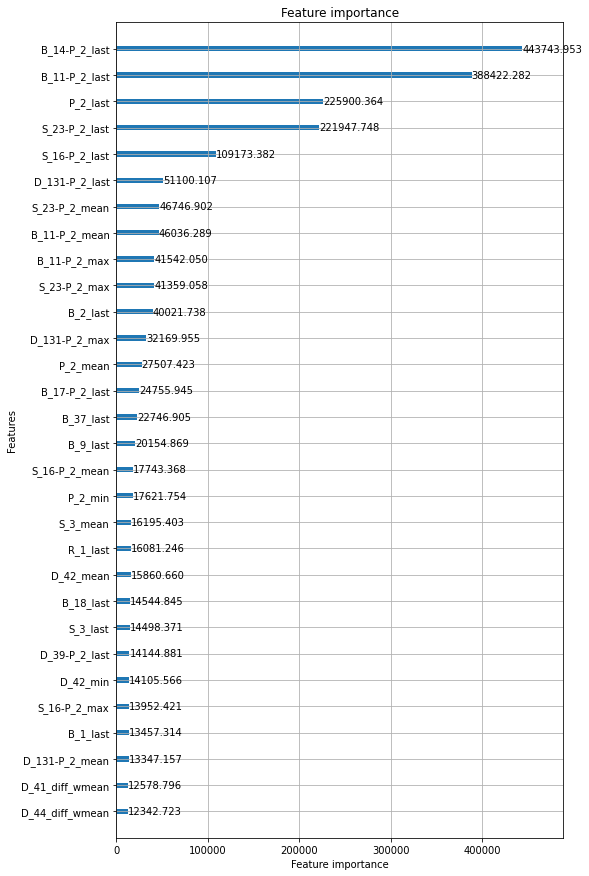

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

Training until validation scores don't improve for 300 rounds


[50]	valid_0's amex_metric: 0.764355	valid_0's recall_at4: 0.62146	valid_0's norm_gini: 0.907251


[100]	valid_0's amex_metric: 0.776053	valid_0's recall_at4: 0.637913	valid_0's norm_gini: 0.914192


[150]	valid_0's amex_metric: 0.782534	valid_0's recall_at4: 0.647339	valid_0's norm_gini: 0.91773


[200]	valid_0's amex_metric: 0.785104	valid_0's recall_at4: 0.650536	valid_0's norm_gini: 0.919671


[250]	valid_0's amex_metric: 0.788412	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.920816


[300]	valid_0's amex_metric: 0.788809	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.921612


[350]	valid_0's amex_metric: 0.789869	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.92209


[400]	valid_0's amex_metric: 0.789902	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.922451


[450]	valid_0's amex_metric: 0.790109	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.922781


[500]	valid_0's amex_metric: 0.790634	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922989


[550]	valid_0's amex_metric: 0.790801	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.923154


[600]	valid_0's amex_metric: 0.79163	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923298


[650]	valid_0's amex_metric: 0.791298	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.923433


[700]	valid_0's amex_metric: 0.791643	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923533


[750]	valid_0's amex_metric: 0.791817	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.92363


[800]	valid_0's amex_metric: 0.792194	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.92371


[850]	valid_0's amex_metric: 0.792527	valid_0's recall_at4: 0.661267	valid_0's norm_gini: 0.923788


[900]	valid_0's amex_metric: 0.793153	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923819


[950]	valid_0's amex_metric: 0.79285	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.923844


[1000]	valid_0's amex_metric: 0.79333	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.92388


[1050]	valid_0's amex_metric: 0.793066	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.923898


[1100]	valid_0's amex_metric: 0.793414	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.92392


[1150]	valid_0's amex_metric: 0.793154	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.923904


[1200]	valid_0's amex_metric: 0.793111	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.923904


[1250]	valid_0's amex_metric: 0.792901	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.923905


[1300]	valid_0's amex_metric: 0.793076	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.923918


[1350]	valid_0's amex_metric: 0.793046	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.923942


[1400]	valid_0's amex_metric: 0.793318	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.923939


[1450]	valid_0's amex_metric: 0.793202	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923918


[1500]	valid_0's amex_metric: 0.793377	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.92393


[1550]	valid_0's amex_metric: 0.793618	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923907


[1600]	valid_0's amex_metric: 0.79355	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.923898


[1650]	valid_0's amex_metric: 0.793605	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923881


[1700]	valid_0's amex_metric: 0.793536	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.92387


[1750]	valid_0's amex_metric: 0.792811	valid_0's recall_at4: 0.661729	valid_0's norm_gini: 0.923892


Early stopping, best iteration is:
[1496]	valid_0's amex_metric: 0.793799	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.923932
Evaluated only: amex_metric


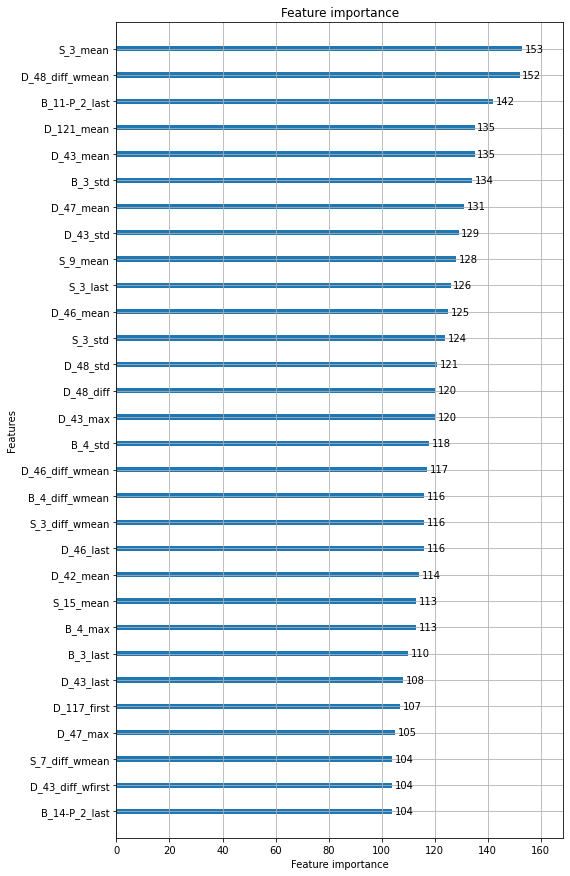

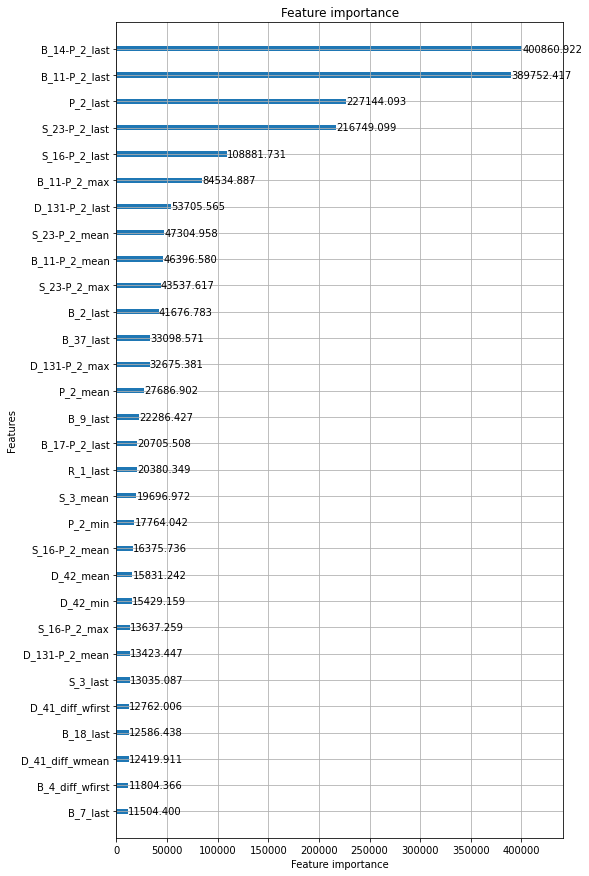

Training time: 16.60994910001755 min.
OOF recall_at4: 0.6654239741475073
OOF normalized_gini: 0.9247603698393415
OOF competition metric: 0.7950921719934244


CPU times: user 9h 24min 49s, sys: 1min 19s, total: 9h 26min 9s
Wall time: 49min 48s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.665264,0.924591,0.794927
1,0.666072,0.924652,0.795362
2,0.665424,0.924760,0.795092



mean:


recall_at4    0.665587
gini          0.924668
metric        0.795127
dtype: float64


std:


recall_at4    0.000428
gini          0.000086
metric        0.000219
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 55min 50s, sys: 54.5 s, total: 56min 45s
Wall time: 5min 54s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.55 s, sys: 839 ms, total: 4.39 s
Wall time: 4.69 s


***